In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# torch.manual_seed(1)

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# input_size = 2 
hidden_size = 400 # randomly chosen
output_size = 1 # we want it to return a number that can be used to calculate the difference from the actual number

class NeuralNetwork(nn.Module):
    def __init__(self,img_dim, output_size):
        
        super(NeuralNetwork, self).__init__()
        
        
        # weights 
#         self.W = torch.randn(img_dim,img_dim , requires_grad=True)

#         self.theta_D = torch.randn(num_img, img_dim, requires_grad=True)
        
        
        self.W = nn.Linear(img_dim,img_dim)
        
        self.discriminator_thetaD = nn.Linear(img_dim,hidden_size)
        self.discriminator_hiddn = nn.Linear(hidden_size,output_size)


        
# Add bias
        self.b1 = torch.randn(img_dim, requires_grad=True)

#         self.b2 = torch.randn(hidden_size, requires_grad=True)
#         self.b3 = torch.randn(output_size, requires_grad=True)
        
        
    def forward(self, img,phase='Discriminate'):
        
        if phase == 'Discriminate':

            self.W.trainable = False
            self.discriminator_thetaD.trainable = True
            self.discriminator_hiddn.trainable = True
            
            
            wTx = self.W(img)

            
            discriminator_hidden_in = self.discriminator_thetaD(wTx)
            out = self.discriminator_hiddn(discriminator_hidden_in)
            out=out.view(-1)

            return nn.Sigmoid()(out)
        
        elif phase == 'Map' :
            self.W.trainable = True
            
            wTx = self.W(img)
            
            self.discriminator_thetaD.trainable = False
            self.discriminator_hiddn.trainable = False
            
            
            discriminator_hidden_in = self.discriminator_thetaD(wTx)
            out = self.discriminator_hiddn(discriminator_hidden_in)
            out = out.view(-1)
            return nn.Sigmoid()(out)
            

            


In [4]:
dimension_space = 300

nne = NeuralNetwork(dimension_space,1).cuda()

In [5]:

learning_rate = 0.01

# create a stochastic gradient descent optimizer
# optimizer = optim.SGD(nne.parameters(), lr=learning_rate, momentum=0.9)

# optimizer = optim.Adam([var1, var2], lr = 0.0001)

optimizer = optim.Adam(nne.parameters(), lr = 0.0001)

# create a loss function
criterion = nn.BCELoss().cuda()

In [6]:
nne

NeuralNetwork(
  (W): Linear(in_features=300, out_features=300, bias=True)
  (discriminator_thetaD): Linear(in_features=300, out_features=400, bias=True)
  (discriminator_hiddn): Linear(in_features=400, out_features=1, bias=True)
)

In [7]:
import numpy as np

num_instances = 30000

input_img = np.random.rand(num_instances,300)
input_text = np.random.rand(num_instances,300)

In [8]:
input_img

array([[0.31991384, 0.15185025, 0.14027145, ..., 0.41714736, 0.87691122,
        0.47720726],
       [0.17759881, 0.88175374, 0.46719948, ..., 0.13981627, 0.13506835,
        0.37412817],
       [0.42214039, 0.02733875, 0.9220513 , ..., 0.27714024, 0.15083715,
        0.21847283],
       ...,
       [0.93365734, 0.6797453 , 0.55035065, ..., 0.93524994, 0.7880637 ,
        0.75098094],
       [0.46353613, 0.158073  , 0.3049391 , ..., 0.35150793, 0.91228123,
        0.04454267],
       [0.47995546, 0.15270007, 0.12566643, ..., 0.89469133, 0.06348797,
        0.50674115]])

In [9]:
num_epochs = 200

In [10]:
discriminator_img_loss = []
discriminator_text_loss = []
mapper_loss = []

In [11]:
for epoch in range(num_epochs):
    
    ## Discriminate. For image, it is 1, saying it comes from different distribution
    outed = nne( Variable(torch.from_numpy(input_img)).cuda().float(),phase='Discriminate')
    loss = criterion(outed,torch.ones(num_instances).cuda())
    discriminator_img_loss.append(loss.cpu().tolist())
    loss.backward()
    optimizer.step()

    ## Discriminate. For text, it is 0 saying it is text, from same distribution 
    outed = nne( Variable(torch.from_numpy(input_text)).cuda().float(),phase='Discriminate')
    loss = criterion(outed,torch.zeros(num_instances).cuda())
    discriminator_text_loss.append(loss.cpu().tolist())
    loss.backward()
    optimizer.step()

    ## Mapper , Training in a way to fool discriminator think that vector from image distribution is from text distribution. 
    outed = nne( Variable(torch.from_numpy(input_img)).cuda().float(),phase='Map')
    loss = criterion(outed,torch.zeros(num_instances).cuda())
    mapper_loss.append(loss.cpu().tolist())
    loss.backward()
    optimizer.step()
    
    
    

In [12]:
discriminator_img_loss

[0.6786667108535767,
 0.5889273285865784,
 0.6837907433509827,
 0.8529072403907776,
 1.070701003074646,
 1.3295073509216309,
 1.6087963581085205,
 1.8505845069885254,
 1.9603993892669678,
 1.8685916662216187,
 1.5931390523910522,
 1.218384861946106,
 0.8406489491462708,
 0.5350297689437866,
 0.3374940752983093,
 0.24572902917861938,
 0.24002037942409515,
 0.3073723018169403,
 0.4525262117385864,
 0.685449481010437,
 1.0019159317016602,
 1.3768162727355957,
 1.7723296880722046,
 2.1466307640075684,
 2.454838991165161,
 2.6472854614257812,
 2.672959566116333,
 2.493110179901123,
 2.103550434112549,
 1.5563292503356934,
 0.970317542552948,
 0.49961888790130615,
 0.22494830191135406,
 0.10207461565732956,
 0.05490829795598984,
 0.03975661098957062,
 0.0412275604903698,
 0.060426015406847,
 0.11612098664045334,
 0.2602151334285736,
 0.5875739455223083,
 1.16707444190979,
 1.9318712949752808,
 2.738297462463379,
 3.4771132469177246,
 4.085101127624512,
 4.522702217102051,
 4.761753559112549,

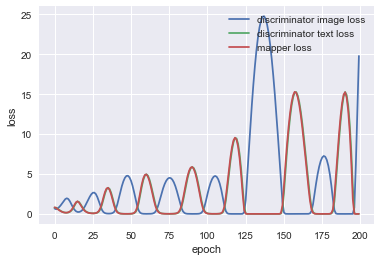

In [13]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot([i for i in range(num_epochs)],discriminator_img_loss,label='discriminator image loss')
plt.plot([i for i in range(num_epochs)],discriminator_text_loss,label='discriminator text loss')
plt.plot([i for i in range(num_epochs)],mapper_loss,label='mapper loss')
plt.legend(loc='upper right')

# Just checking the updatability property

In [33]:
outed = nne( Variable(torch.from_numpy(input_img)).cuda().float(),phase='Discriminate')

torch.Size([1000, 300])
tensor([ 0.0243,  0.0047, -0.0256, -0.0169, -0.0442, -0.0453, -0.1131,  0.0551,
        -0.0461,  0.0131,  0.0519,  0.0186, -0.0191, -0.0738, -0.0868, -0.0707,
        -0.0226,  0.0006, -0.0329,  0.0205, -0.0221,  0.0183,  0.0319,  0.0362,
         0.0515,  0.0514, -0.0122, -0.0770, -0.0497,  0.0008, -0.0819,  0.0071,
        -0.0512, -0.0012,  0.0327, -0.0019, -0.0556, -0.0267, -0.0287, -0.0166,
         0.0016, -0.0660,  0.0065, -0.0451,  0.0758, -0.0044,  0.0253, -0.0338,
        -0.0209, -0.0469,  0.0516, -0.0378, -0.0738,  0.0784, -0.1040, -0.0703,
         0.0091, -0.0075,  0.0051,  0.0458, -0.0339, -0.0340, -0.0475, -0.0467,
        -0.0878, -0.0285, -0.1398, -0.0908, -0.0277, -0.1045, -0.0224, -0.0489,
         0.0037,  0.0161, -0.0523, -0.0347,  0.0011, -0.0794, -0.0041,  0.0271,
         0.0117, -0.1007,  0.0237, -0.0649, -0.0836, -0.1281,  0.0106,  0.0707,
        -0.1287, -0.0866,  0.0326, -0.0007, -0.0241, -0.1051, -0.0956, -0.0516,
         0.0193,

In [ ]:
nne.W.weight

In [ ]:
nne.discriminator_thetaD.weight

In [31]:
nne.discriminator_hiddn.weight

Parameter containing:
tensor([[ 0.0006,  0.0216,  0.0131, -0.0242,  0.0107, -0.0143, -0.0436, -0.0113,
          0.0087, -0.0412, -0.0004, -0.0240,  0.0111, -0.0146,  0.0184, -0.0101,
          0.0460, -0.0332,  0.0337, -0.0290, -0.0135,  0.0047,  0.0121, -0.0353,
          0.0155,  0.0205, -0.0298, -0.0323,  0.0456,  0.0313, -0.0143,  0.0055,
          0.0454, -0.0184,  0.0489,  0.0112, -0.0038, -0.0038,  0.0149,  0.0404,
         -0.0413, -0.0286, -0.0194, -0.0440,  0.0348, -0.0469, -0.0143, -0.0333,
         -0.0257, -0.0161,  0.0096, -0.0213, -0.0126, -0.0290, -0.0162,  0.0383,
         -0.0332, -0.0217,  0.0303, -0.0425,  0.0075, -0.0311, -0.0349, -0.0366,
          0.0443, -0.0250,  0.0287, -0.0406, -0.0266,  0.0068, -0.0145, -0.0291,
         -0.0063,  0.0451, -0.0136,  0.0085, -0.0191, -0.0369, -0.0268,  0.0104,
          0.0069, -0.0217,  0.0350, -0.0035, -0.0396, -0.0074,  0.0164,  0.0444,
          0.0185,  0.0406, -0.0122, -0.0413,  0.0199, -0.0208,  0.0218, -0.0325,
      

In [32]:
outed.shape

torch.Size([1000])

In [21]:
loss = criterion(outed,torch.ones(1000))
loss.backward()
optimizer.step()

In [22]:
nne.W.weight

Parameter containing:
tensor([[ 0.0297, -0.0255, -0.0112,  ...,  0.0007, -0.0330, -0.0323],
        [-0.0087, -0.0167,  0.0141,  ..., -0.0150, -0.0009,  0.0567],
        [ 0.0388, -0.0043,  0.0566,  ...,  0.0475, -0.0140,  0.0021],
        ...,
        [ 0.0479,  0.0255,  0.0026,  ..., -0.0493, -0.0470,  0.0084],
        [-0.0123, -0.0536, -0.0290,  ...,  0.0452,  0.0064, -0.0413],
        [ 0.0074,  0.0007,  0.0109,  ..., -0.0207,  0.0500,  0.0514]],
       requires_grad=True)

In [23]:
nne.discriminator_thetaD.weight

Parameter containing:
tensor([[-0.0299, -0.0288, -0.0171,  ...,  0.0355,  0.0556, -0.0168],
        [ 0.0153, -0.0307,  0.0017,  ..., -0.0024, -0.0273,  0.0022],
        [-0.0444, -0.0501, -0.0237,  ..., -0.0554, -0.0141,  0.0302],
        ...,
        [ 0.0416, -0.0026, -0.0562,  ..., -0.0080, -0.0514, -0.0418],
        [ 0.0553,  0.0548, -0.0161,  ..., -0.0388, -0.0459, -0.0495],
        [ 0.0285,  0.0144, -0.0449,  ..., -0.0126,  0.0344, -0.0138]],
       requires_grad=True)